<a href="https://colab.research.google.com/github/bathaee/QGAN-EQ-GAN/blob/main/Measurement_error_mitigation_(practice).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install qiskit --upgrade
!pip install qiskit-machine-learning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 45.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 39.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.5/241.5 kB 23.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 47.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.5/37.5 MB 11.7 MB/s eta 0:00:00


In [9]:
!pip install qiskit_terra

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
!pip install qiskit-ignis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
!pip install qiskit_experiments

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.1/806.1 kB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.7/56.7 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 186.2/186.2 kB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.4/98.4 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.1/101.1 kB 9.3 MB/s eta 0:00:00


In [3]:
# Import Qiskit classes
import qiskit
from qiskit import QuantumRegister, QuantumCircuit, ClassicalRegister
from qiskit_aer import noise # import AER noise model

# Measurement error mitigation functions
from qiskit.ignis.mitigation.measurement import (complete_meas_cal,
                                                 CompleteMeasFitter, 
                                                 MeasurementFilter)

# Generate a noise model for the qubits
noise_model = noise.NoiseModel()
for qi in range(5):
    read_err = noise.errors.readout_error.ReadoutError([[0.75, 0.25],[0.1, 0.9]])
    noise_model.add_readout_error(read_err, [qi])

# Generate the measurement calibration circuits
# for running measurement error mitigation
qr = QuantumRegister(5)
meas_cals, state_labels = complete_meas_cal(qubit_list=[2,3,4], qr=qr)

# Execute the calibration circuits
backend = qiskit.Aer.get_backend('qasm_simulator')
job = qiskit.execute(meas_cals, backend=backend, shots=1000, noise_model=noise_model)
cal_results = job.result()

# Make a calibration matrix
meas_fitter = CompleteMeasFitter(cal_results, state_labels)

# Make a 3Q GHZ state
cr = ClassicalRegister(3)
ghz = QuantumCircuit(qr, cr)
ghz.h(qr[2])
ghz.cx(qr[2], qr[3])
ghz.cx(qr[3], qr[4])
ghz.measure(qr[2],cr[0])
ghz.measure(qr[3],cr[1])
ghz.measure(qr[4],cr[2])

# Execute the GHZ circuit (with the same noise model)
job = qiskit.execute(ghz, backend=backend, shots=1000, noise_model=noise_model)
results = job.result()

# Results without mitigation
raw_counts = results.get_counts()
print("Results without mitigation:", raw_counts)

# Create a measurement filter from the calibration matrix
meas_filter = meas_fitter.filter
# Apply the filter to the raw counts to mitigate 
# the measurement errors
mitigated_counts = meas_filter.apply(raw_counts)
print("Results with mitigation:", {l:int(mitigated_counts[l]) for l in mitigated_counts})

<ipython-input-3-3dc8349d9226>:7: DeprecationWarning: The qiskit.ignis package is deprecated and has been supersceded by the qiskit-experiments project. Refer to the migration guide: https://github.com/Qiskit/qiskit-ignis#migration-guide on how to migrate to the new project.
  from qiskit.ignis.mitigation.measurement import (complete_meas_cal,


Results without mitigation: {'101': 61, '010': 72, '000': 217, '001': 86, '100': 75, '011': 59, '111': 364, '110': 66}
Results with mitigation: {'000': 502, '001': 7, '010': 0, '011': 0, '100': 9, '101': 8, '110': 3, '111': 468}


In [17]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit
from qiskit.visualization import plot_histogram
from qiskit_experiments.library import LocalReadoutError, CorrelatedReadoutError

from qiskit_aer import AerSimulator
from qiskit.providers.fake_provider import FakePerth

from qiskit.result.mitigation.utils import (
    expval_with_stddev,
    str2diag,
    counts_probability_vector
)

backend = AerSimulator.from_backend(FakePerth())

In [18]:
shots = 1024
qubits = [0,1,2,3]
num_qubits = len(qubits)
exp = LocalReadoutError(qubits)
for c in exp.circuits():
    print(c)

         ░ ┌─┐         
   q_0: ─░─┤M├─────────
         ░ └╥┘┌─┐      
   q_1: ─░──╫─┤M├──────
         ░  ║ └╥┘┌─┐   
   q_2: ─░──╫──╫─┤M├───
         ░  ║  ║ └╥┘┌─┐
   q_3: ─░──╫──╫──╫─┤M├
         ░  ║  ║  ║ └╥┘
meas: 4/════╩══╩══╩══╩═
            0  1  2  3 
        ┌───┐ ░ ┌─┐         
   q_0: ┤ X ├─░─┤M├─────────
        ├───┤ ░ └╥┘┌─┐      
   q_1: ┤ X ├─░──╫─┤M├──────
        ├───┤ ░  ║ └╥┘┌─┐   
   q_2: ┤ X ├─░──╫──╫─┤M├───
        ├───┤ ░  ║  ║ └╥┘┌─┐
   q_3: ┤ X ├─░──╫──╫──╫─┤M├
        └───┘ ░  ║  ║  ║ └╥┘
meas: 4/═════════╩══╩══╩══╩═
                 0  1  2  3 


In [19]:
exp.analysis.set_options(plot=True)
result = exp.run(backend)
mitigator = result.analysis_results(0).value

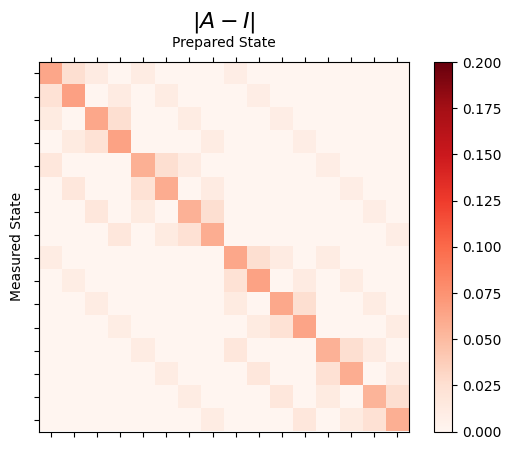

In [20]:
result.figure(0)

In [21]:
for m in mitigator._mitigation_mats:
    print(m)
    print()

[[ 1.02466598 -0.02774923]
 [-0.02466598  1.02774923]]

[[ 1.01301301 -0.01201201]
 [-0.01301301  1.01201201]]

[[ 1.01809045 -0.01105528]
 [-0.01809045  1.01105528]]

[[ 1.0109671  -0.00997009]
 [-0.0109671   1.00997009]]



In [22]:
qc = QuantumCircuit(num_qubits)
qc.h(0)
for i in range(1, num_qubits):
    qc.cx(i - 1, i)
qc.measure_all()
print(qc)

        ┌───┐                ░ ┌─┐         
   q_0: ┤ H ├──■─────────────░─┤M├─────────
        └───┘┌─┴─┐           ░ └╥┘┌─┐      
   q_1: ─────┤ X ├──■────────░──╫─┤M├──────
             └───┘┌─┴─┐      ░  ║ └╥┘┌─┐   
   q_2: ──────────┤ X ├──■───░──╫──╫─┤M├───
                  └───┘┌─┴─┐ ░  ║  ║ └╥┘┌─┐
   q_3: ───────────────┤ X ├─░──╫──╫──╫─┤M├
                       └───┘ ░  ║  ║  ║ └╥┘
meas: 4/════════════════════════╩══╩══╩══╩═
                                0  1  2  3 


In [23]:
counts = backend.run(qc, shots=shots, seed_simulator=42, method="density_matrix").result().get_counts()
unmitigated_probs = {label: count / shots for label, count in counts.items()}

In [24]:
mitigated_quasi_probs = mitigator.quasi_probabilities(counts)
mitigated_stddev = mitigated_quasi_probs._stddev_upper_bound
mitigated_probs = (mitigated_quasi_probs.nearest_probability_distribution().binary_probabilities())

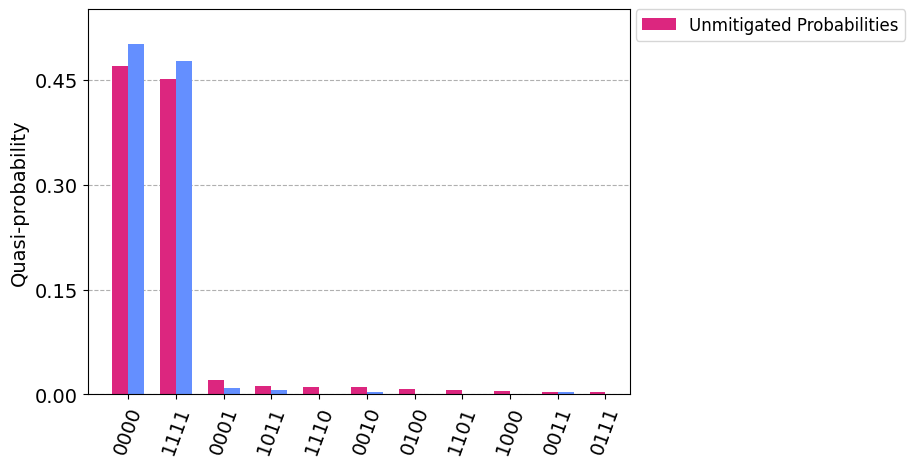

In [25]:
legend = ['Mitigated Probabilities', 'Unmitigated Probabilities']
plot_histogram([mitigated_probs, unmitigated_probs], legend=legend, sort="value_desc", bar_labels=False)

In [40]:
from qiskit import QuantumCircuit
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes

from qiskit_machine_learning.neural_networks import SamplerQNN

num_qubits = 2
feature_map = ZZFeatureMap(feature_dimension=num_qubits)
ansatz = RealAmplitudes(num_qubits=num_qubits, reps=1)

qc = QuantumCircuit(num_qubits)
qc.compose(feature_map, inplace=True)
qc.compose(ansatz, inplace=True)
qc.measure_all()

print(qc.decompose())

def parity(x):
  return "{:b}".format(x).count("0") % 2

qnn = SamplerQNN(
            circuit=qc,
            input_params=feature_map.parameters,
            weight_params=ansatz.parameters,
            interpret=parity,
            output_shape=2
        )

qnn.forward(input_data=[1, 2], weights=[1, 2, 3, 4])








        ┌───┐┌─────────────┐                                          ┌───┐»
   q_0: ┤ H ├┤ P(2.0*x[0]) ├──■────────────────────────────────────■──┤ H ├»
        ├───┤├─────────────┤┌─┴─┐┌──────────────────────────────┐┌─┴─┐├───┤»
   q_1: ┤ H ├┤ P(2.0*x[1]) ├┤ X ├┤ P(2.0*(π - x[0])*(π - x[1])) ├┤ X ├┤ H ├»
        └───┘└─────────────┘└───┘└──────────────────────────────┘└───┘└───┘»
meas: 2/═══════════════════════════════════════════════════════════════════»
                                                                           »
«        ┌─────────────┐                                          ┌──────────┐»
«   q_0: ┤ P(2.0*x[0]) ├──■────────────────────────────────────■──┤ Ry(θ[0]) ├»
«        ├─────────────┤┌─┴─┐┌──────────────────────────────┐┌─┴─┐├──────────┤»
«   q_1: ┤ P(2.0*x[1]) ├┤ X ├┤ P(2.0*(π - x[0])*(π - x[1])) ├┤ X ├┤ Ry(θ[1]) ├»
«        └─────────────┘└───┘└──────────────────────────────┘└───┘└──────────┘»
«meas: 2/════════════════════════════════════════════════════

array([[0.863194, 0.136806]])

In [ ]:

counts = backend.run(qc.decompose(), shots=shots, seed_simulator=42, method="density_matrix").result().get_counts()
unmitigated_probs = {label: count / shots for label, count in counts.items()}

mitigated_quasi_probs = mitigator.quasi_probabilities(counts)
mitigated_stddev = mitigated_quasi_probs._stddev_upper_bound
mitigated_probs = (mitigated_quasi_probs.nearest_probability_distribution().binary_probabilities())
